## Train energy prediction models for on-top and hollow sites

In this notebook I will train two models that predicts energy for an adsorbate based on a feature vector made from the nearby metal atoms at the adsorption site. The input data is .csv files with extracted feature vectors and energies from DFT data in .db files.

I will train:
* XGBoost regressor for on-top site (OH)
* XGBoost regressor for hollow site (O and H)

#### Import packages

In [1]:
import warnings
warnings.filterwarnings('ignore')

import xgboost;
from xgboost import XGBRegressor;
import pandas as pd;
from sklearn.model_selection import train_test_split;
from xgboost import plot_importance;
import numpy as np

import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, InsetPosition
import matplotlib.ticker as ticker

import random
random.seed(1)
np.random.seed(1)

import time

figure_folder = "../figures/"

In [2]:
def learning_curve(model_name): #For regressor
    # retrieve performance metrics
    results = model_name.evals_result()
    epochs = len(results['validation_0']['mae'])
    x_axis = range(0, epochs)
    
    # plot log loss
    fig, ax = plt.subplots(figsize=(10,4))
    ax.plot(x_axis, results['validation_0']['mae'], label='Train')
    ax.plot(x_axis, results['validation_1']['mae'], label='Validation')
    ax.legend()
    
    plt.xlabel("Epoch")
    plt.ylabel('Log Loss')
    plt.title('XGBoost Loss curve')
    plt.show()
    return None

def single_parity_plot(model_name, X_test, y_test_series, training_data, adsorbate):
    model_predictions = model_name.predict(X_test)
    
    model_type_title = "Gradient Boosting"
    #Fix sklearn LinearRegressions weird list of lists thing
    if len(np.shape(model_predictions)) == 2:
        #print("For søren, jeg har fået en LinearRegression model fra sklearn. Sikke skørt det er at returnere predictions som en liste af en liste. Det vil jeg straks rette op på")
        #print("model_predictions: ", model_predictions)
        model_predictions = model_predictions.reshape(-1)
        #print("model_predictions after reshaping: ", model_predictions)
        
        #Sørg for at den skriver linear regression model i titlen
        model_type_title = "Linear Regression"
    
    y_test = y_test_series.values.tolist()
    
    # Find MAE:
    errors = y_test_series.to_numpy().reshape(-1)-model_predictions
    MAE = np.mean(np.abs(errors))
    #print(f"MAE: {MAE:.3f}")

    if adsorbate == "H and O":
        #I want two plt.scatter, one for each adsorbate
        flat_list = [item for sublist in X_test[["adsorbate"]].values.tolist() for item in sublist]
        pred_H = [model_predictions[n] for n in range(len(y_test)) if flat_list[n] == 0]
        pred_O = [model_predictions[n] for n in range(len(y_test)) if flat_list[n] == 1]
        true_H = [y_test[n] for n in range(len(y_test)) if flat_list[n] == 0]
        true_O = [y_test[n] for n in range(len(y_test)) if flat_list[n] == 1]
        
        MAE_O = np.mean(np.abs(np.array(true_O).reshape(-1)-pred_O))
        MAE_H = np.mean(np.abs(np.array(true_H).reshape(-1)-pred_H))
        print(f"MAE(O): {MAE_O:.3f}")
        print(f"MAE(H): {MAE_H:.3f}")
    
    fig, ax1 = plt.subplots()
    
    if adsorbate == "H and O":
        ax1.scatter(true_H, pred_H, s = 20, c = "tab:green", label = "Adsorbate: H", marker = "$H$")
        ax1.scatter(true_O, pred_O, s = 20, c = "tab:red", label = "Adsorbate: O", marker = "$O$")
        
        ax1.set_title(model_type_title + " model predictions of $\Delta G_{*O}^{DFT} (eV)$ and $\Delta G_{*H}^{DFT} (eV)$ \n Training data: " + training_data)
    
        
    if adsorbate == "OH":
        ax1.scatter(y_test_series, model_predictions, s = 60, c = "tab:blue", label = "Adsorbate: OH", marker = "$OH$")
        ax1.set_title(model_type_title + " model predictions of $\Delta G_{*OH}^{DFT} (eV)$")
    
    ax1.set_xlabel("$\Delta G_{*Adsorbate}^{DFT} (eV)$")
    ax1.set_ylabel("$\Delta G_{*Adsorbate}^{Pred} (eV)$")
    
    ax1.text(0.8, 2.4, f"MAE(test) = {MAE:.3f}", color="deepskyblue", fontweight='bold', fontsize = 12)
    
    left, bottom, width, height = [0.16, 0.65, 0.2, 0.2]
    ax_inset = fig.add_axes([left, bottom, width, height])
    
    pm, lw, fontsize = 0.1, 0.5, 14

    ax_inset.hist(errors, bins=np.arange(-0.6, 0.6, 0.05),
          color="deepskyblue",
          density=True,
          alpha=0.7,
          histtype='stepfilled',
          ec='black',
          lw=lw)
    
    # Make plus/minus 0.1 eV lines in inset axis
    ax_inset.axvline(pm, color='black', ls='--', dashes=(5, 5), lw=lw)
    ax_inset.axvline(-pm, color='black', ls='--', dashes=(5, 5), lw=lw)
    
    # Set x-tick label fontsize in inset axis
    ax_inset.tick_params(axis='x', which='major', labelsize=fontsize-6)
    
    # Remove y-ticks in inset axis
    ax_inset.tick_params(axis='y', which='major', left=False, labelleft=False)
    
    # Set x-tick locations in inset axis
    ax_inset.xaxis.set_major_locator(ticker.MultipleLocator(0.50))
    ax_inset.xaxis.set_minor_locator(ticker.MultipleLocator(0.25))
    
    # Remove the all but the bottom spines of the inset axis
    for side in ['top', 'right', 'left']:
        ax_inset.spines[side].set_visible(False)
    
    # Make the background transparent in the inset axis
    ax_inset.patch.set_alpha(0.0)
    
    # Print 'pred-calc' below inset axis
    ax_inset.text(0.5, -0.33,
                  '$pred - DFT$ (eV)',
                  ha='center',
                  transform=ax_inset.transAxes,
                  fontsize=fontsize-7)
    
    # Make central and plus/minus 0.1 eV lines in scatter plot
    lims = [-0.3, 2.75]
    
    # Set x and y limits
    ax1.set_xlim(lims)
    ax1.set_ylim(lims)
    
    ax1.plot(lims, lims,
            lw=lw, color='black', zorder=1,
            label=r'$\rm \Delta G_{pred} = \Delta G_{DFT}$')
    
    # Make plus/minus 0.1 eV lines around y = x
    ax1.plot(lims, [lims[0]+pm, lims[1]+pm],
            lw=lw, ls='--', dashes=(5, 5), color='black', zorder=1,
            label=r'$\rm \pm$ {:.1f} eV'.format(pm))
            
    ax1.plot([lims[0], lims[1]], [lims[0]-pm, lims[1]-pm],
            lw=lw, ls='--', dashes=(5, 5), color='black', zorder=1)
    
    ax1.legend(frameon=False,
          bbox_to_anchor=[0.45, 0.0],
          loc='lower left',
          handletextpad=0.2,
          handlelength=1.0,
          labelspacing=0.2,
          borderaxespad=0.1,
          markerscale=1.5,
          fontsize=fontsize-5)
    
    #plt.savefig(figure_folder + "Parity_trained_OH_tested_BOTH.png", dpi = 300, bbox_inches = "tight")
    # Save figure with a random name, rename later
    #plt.savefig(figure_folder + str(time.time())[6:10]+str(time.time())[11:15], dpi = 300, bbox_inches = "tight")
    plt.show()
    return None

def prepare_csv(feature_folder, filename, adsorbate):
    init_df = pd.read_csv(feature_folder + filename)

    # Add a first column about the adsorbate
    adsorbate_df = pd.DataFrame([adsorbate for x in range(len(init_df))], columns = ["adsorbate"])

    #Combine
    prepared_df = pd.concat([adsorbate_df, init_df], axis = 1)
    return prepared_df

def return_mae(model_name, X_test, y_test_series): #Returns MAE on test set for a model (Either XGBoost or )
    model_predictions = model_name.predict(X_test)
    
    if len(np.shape(model_predictions)) == 2:
        model_predictions = model_predictions.reshape(-1)
    y_test = y_test_series.values.tolist()
    
    # Find MAE:
    errors = y_test_series.to_numpy().reshape(-1)-model_predictions
    MAE = np.mean(np.abs(errors))
    return MAE

## Model trained on all data (Hollow site H and hollow site O)

#### Import data from .csv files to a Pandas Dataframe

In [3]:
feature_folder = "../csv_features/"

# Let's import O and H first. Add an initial row that says "I'm an O" or "I'm an H". The hollow model will take care of seperating them. But the data might share patterns that the model can use, even though the adsorbate is different.

H_df = prepare_csv(feature_folder, "H_features.csv", 0) #H kalder vi 0
O_df = prepare_csv(feature_folder, "O_features.csv", 1) #O kalder vi 1
OH_df = prepare_csv(feature_folder, "OH_features.csv", 2) #OH kalder vi 2

full_df = pd.concat([H_df, O_df], axis = 0)
all_cols = full_df.columns
#Seperate the energies and remove the useless columns

X = full_df.loc[:, :all_cols[-5]]
y = full_df[["G_ads(eV)"]]

In [4]:
# Prepare data for XGBoost

#shuffle and split
X_train, X_val_test, y_train, y_val_test = train_test_split(X, y, test_size = 0.2)
X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, test_size = 0.5)

# Prepare XGBoost 
eval_set = [(X_train, y_train), (X_val, y_val)]
XGBModel_O_H =  XGBRegressor(learning_rate = 0.1 #learning rate
                                , max_depth = 5     #maximum tree depth
                                , n_estimators = 500 #number of boosting rounds
                                , n_jobs = 8 #number of threads
                                , use_label_encoder = False)

XGBModel_O_H.fit(X_train, y_train
                       , eval_set = eval_set
                       , early_stopping_rounds = 5
                       , eval_metric = ["mae"]
                       , verbose = False) #evals


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.1, max_delta_step=0,
             max_depth=5, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=500, n_jobs=8,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             use_label_encoder=False, validate_parameters=1, verbosity=None)

In [6]:
XGBModel_O_H.predict(X_test)

array([ 2.00881910e+00,  1.74819753e-01,  2.25788891e-01,  2.31158209e+00,
        1.71684191e-01,  4.68564570e-01,  2.20559907e+00,  9.74366069e-02,
        2.10459709e+00,  1.81677043e+00, -1.54218283e-02,  1.40773714e+00,
        6.27882034e-03,  2.31350446e+00,  8.82538036e-02,  1.15361989e-01,
        1.78168982e-01,  1.64112639e+00,  3.70258003e-01,  2.16603085e-01,
        2.06863213e+00,  2.68465662e+00,  2.15879846e+00,  1.63004827e+00,
        1.77654779e+00,  4.06310111e-01,  1.92838156e+00,  4.03105795e-01,
       -2.82779671e-02,  2.08815843e-01,  1.70141578e+00,  1.98459280e+00,
        1.84859371e+00,  1.80432367e+00,  1.16424847e+00,  1.30317420e-01,
        2.13832602e-01,  2.44906977e-01,  2.45022321e+00,  3.82207990e-01,
        5.88557497e-02,  7.35045075e-02,  1.80125988e+00,  1.79082334e+00,
       -1.68578047e-02,  1.61977577e+00, -6.90156501e-03,  1.07794078e-02,
        1.05814658e-01,  7.34205320e-02,  1.83499575e+00,  1.55020940e+00,
        1.89076412e+00, -

In [12]:
# Save model in the /models folder
XGBModel_O_H.save_model("../models/"+"Hollow_site.model")


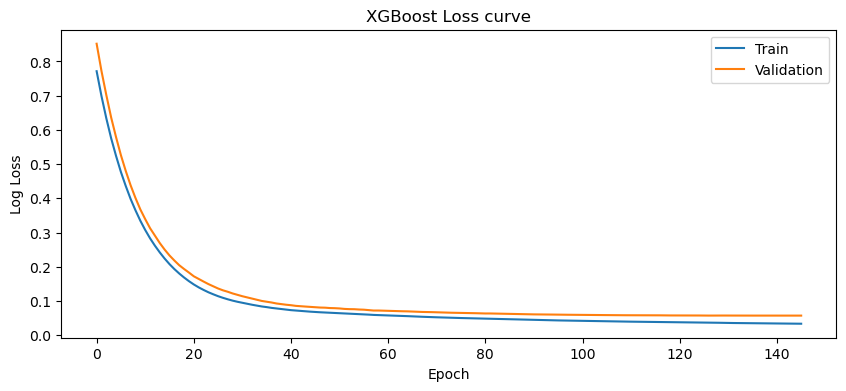

Training score:  0.9974522041813622
Validation score:  0.9938214376954198


In [5]:
learning_curve(XGBModel_O_H)

score = XGBModel_O_H.score(X_train, y_train) #Det må man ikke før den er blevet trænet
print("Training score: ", score)

score = XGBModel_O_H.score(X_val, y_val) #Det må man ikke før den er blevet trænet
print("Validation score: ", score)


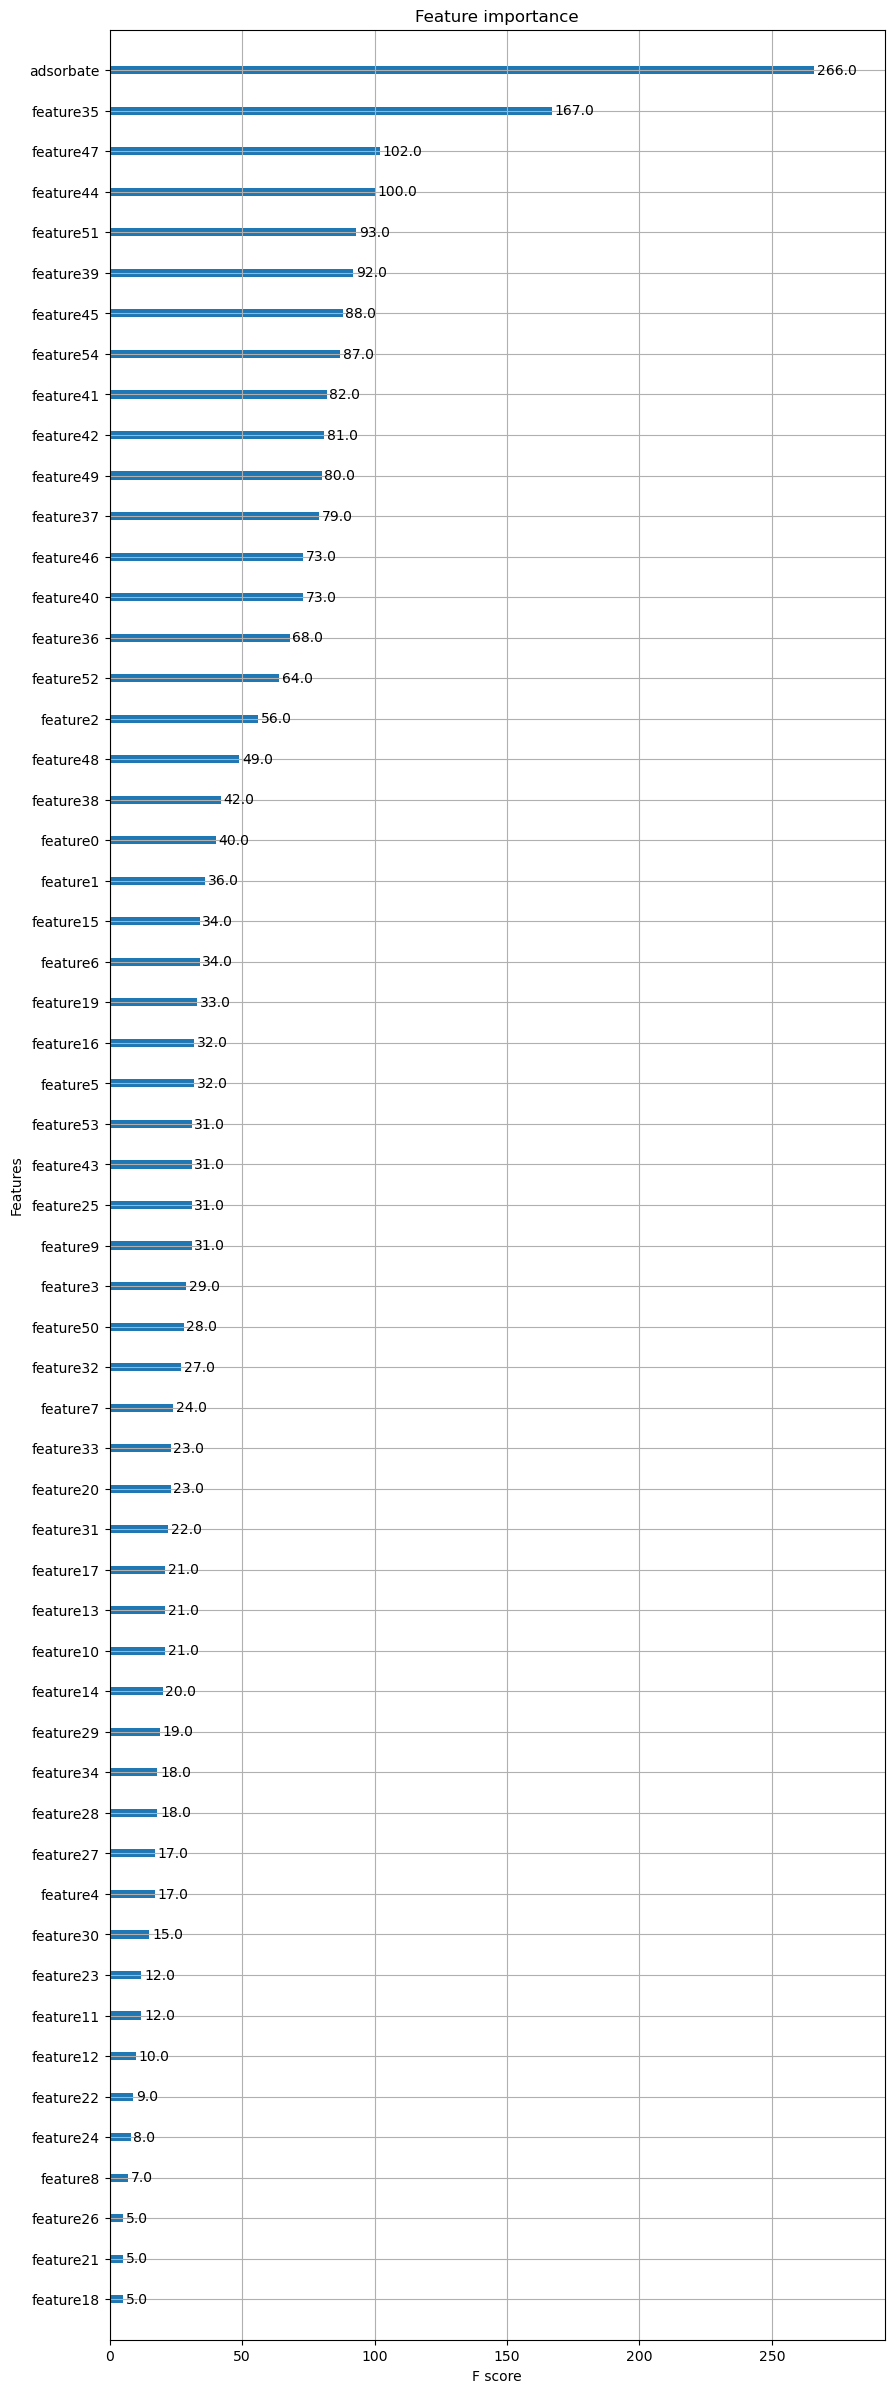

In [6]:
fig, ax = plt.subplots(1, 1, figsize = (10, 30))
plot_importance(XGBModel_O_H, ax = ax, max_num_features = 160)
plt.show()

In [7]:
# Trying to train a better model - Randomsearching parameters
if False:
    from sklearn.model_selection import RandomizedSearchCV
    
    params = { 'max_depth': list(range(3, 10)),
               'learning_rate': np.arange(0.01, 0.3, 0.0001),
               'subsample': np.arange(0.5, 1.0, 0.001),
               'colsample_bytree': np.arange(0.4, 1.0, 0.001),
               'colsample_bylevel': np.arange(0.4, 1.0, 0.001),
               'n_estimators': [150],
               'n_jobs': [8],
               'eval_metric': ["mae"]}
               #'objective': 'binary:logistic'}
    
    xgbr = XGBRegressor(seed = 42)
    clf = RandomizedSearchCV(estimator=xgbr,
                             param_distributions=params,
                             scoring='neg_mean_absolute_error',
                             n_iter=50,
                             verbose=2)
    clf.fit(X, y)
    print("Best parameters:", clf.best_params_)
    print("Lowest -MAE: ", (-clf.best_score_)**(1/2.0))

In [8]:
### Using the best parameters found from random_search

eval_set = [(X_train, y_train), (X_val, y_val)]
XGBModel_O_H_Pro =  XGBRegressor(learning_rate = 0.0824 #learning rate
                                , max_depth = 9     #maximum tree depth
                                , n_estimators = 500 #number of boosting rounds
                                #, early_stopping_rounds = 5
                                , n_jobs = 8 #number of threads
                                , subsample = 0.637
                                , colsample_bytree = 0.979
                                , colsample_bylevel = 0.822
                                , use_label_encoder = False)

XGBModel_O_H_Pro.fit(X_train, y_train, eval_set = eval_set
                  , early_stopping_rounds = 5
                  , eval_metric = ["mae"]
                  , verbose = False)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=0.822,
             colsample_bynode=1, colsample_bytree=0.979,
             enable_categorical=False, gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.0824, max_delta_step=0,
             max_depth=9, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=500, n_jobs=8,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=0.637,
             tree_method='exact', use_label_encoder=False,
             validate_parameters=1, verbosity=None)

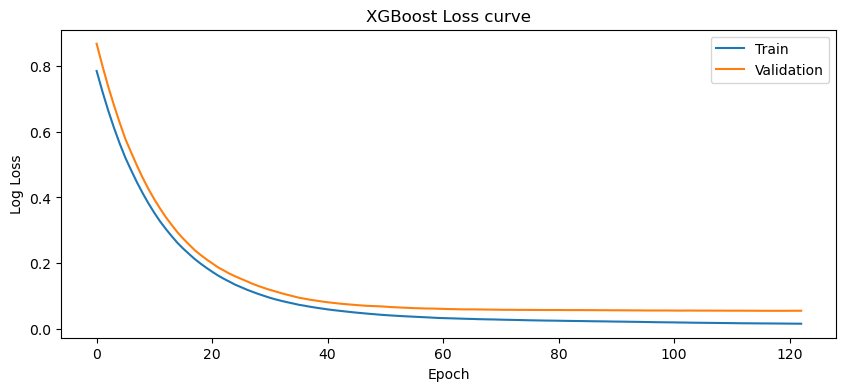

Training score:  0.9993457169893721
Validation score:  0.9949238627496916


In [9]:
learning_curve(XGBModel_O_H_Pro)

score = XGBModel_O_H_Pro.score(X_train, y_train) #Det må man ikke før den er blevet trænet
print("Training score: ", score)

score = XGBModel_O_H_Pro.score(X_val, y_val) #Det må man ikke før den er blevet trænet
print("Validation score: ", score)

## Parity plot

In [10]:
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, InsetPosition
import matplotlib.ticker as ticker

figure_folder = "../figures/"

MAE(O): 0.060
MAE(H): 0.047


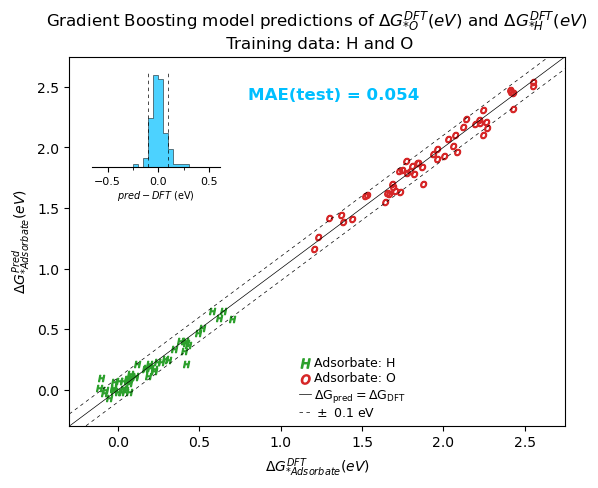

MAE(O): 0.060
MAE(H): 0.050


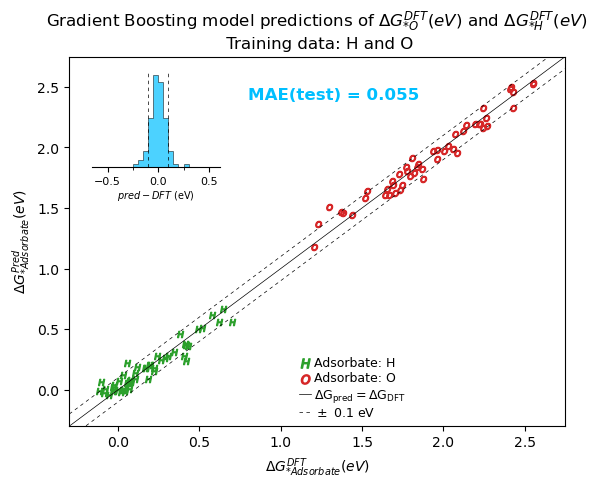

In [11]:
single_parity_plot(XGBModel_O_H, X_test, y_test, "H and O")
single_parity_plot(XGBModel_O_H_Pro, X_test, y_test, "H and O")

MAE(O): 0.031
MAE(H): 0.038


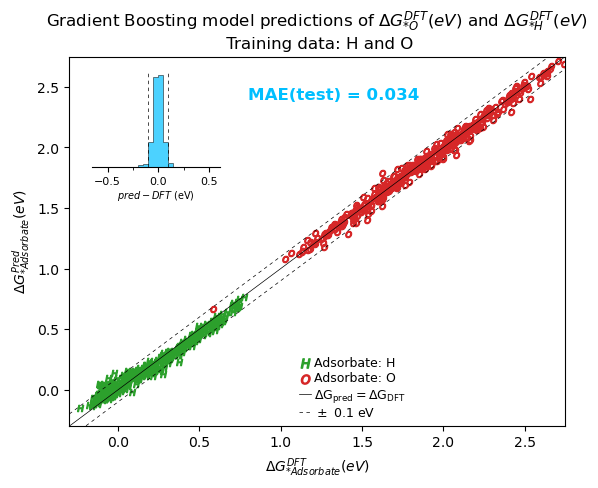

MAE(O): 0.015
MAE(H): 0.020


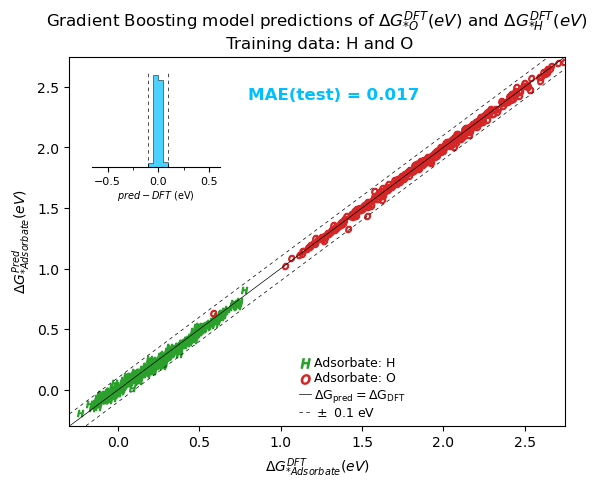

In [12]:
# This is just to illustrate what happens when testing on the training set
single_parity_plot(XGBModel_O_H, X_train, y_train, "H and O")
single_parity_plot(XGBModel_O_H_Pro, X_train, y_train, "H and O")

In [13]:
# Measuring MAE 100 times real quick - XGB trained on both H and O
print("XGBoost model trained and tested on H and O")
MAE_OH = []
MAE_H = []
MAE_O = []
for iteration in range(100):
    # Scramble dataset
    X_train, X_val_test, y_train, y_val_test = train_test_split(X, y, test_size = 0.2)
    X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, test_size = 0.5)
    
    # Prepare XGBoost 
    eval_set = [(X_train, y_train), (X_val, y_val)]
    XGBModel_O_H =  XGBRegressor(learning_rate = 0.1 #learning rate
                                    , max_depth = 5     #maximum tree depth
                                    , n_estimators = 500 #number of boosting rounds
                                    , n_jobs = 8 #number of threads
                                    , use_label_encoder = False)
     # Train
    XGBModel_O_H.fit(X_train, y_train
                           , eval_set = eval_set
                           , early_stopping_rounds = 5
                           , eval_metric = ["mae"]
                           , verbose = False) #evals
   
    # Measure MAE
    MAE_OH.append(return_mae(XGBModel_O_H, X_test, y_test))
    
    model_predictions = XGBModel_O_H.predict(X_test)
    
    #I want two plt.scatter, one for each adsorbate
    flat_list = [item for sublist in X_test[["adsorbate"]].values.tolist() for item in sublist]
    pred_H = [model_predictions[n] for n in range(len(y_test)) if flat_list[n] == 0]
    pred_O = [model_predictions[n] for n in range(len(y_test)) if flat_list[n] == 1]
    y_test = y_test.values.tolist()
    true_H = [y_test[n] for n in range(len(y_test)) if flat_list[n] == 0]
    true_O = [y_test[n] for n in range(len(y_test)) if flat_list[n] == 1]
    
    #print("\n pred_H:", pred_H)
    #print("\n pred_O:", pred_O)
    #print("\n true_H:", true_H)
    #print("\n true_O:", true_O)
    
    MAE_O.append(np.mean(np.abs(np.array(true_O).reshape(-1)-pred_O)))
    MAE_H.append(np.mean(np.abs(np.array(true_H).reshape(-1)-pred_H)))

print("Mean MAE OH: ", np.mean(MAE_OH), ". Standard deviation: ", np.std(MAE_OH))
print("Mean MAE O: ",  np.mean(MAE_O),  ". Standard deviation: ", np.std(MAE_O))
print("Mean MAE H: ",  np.mean(MAE_H),  ". Standard deviation: ", np.std(MAE_H))


XGBoost model trained and tested on H and O
Mean MAE OH:  0.057293354977396176 . Standard deviation:  0.005690755474924776
Mean MAE O:  0.055752419822194935 . Standard deviation:  0.005829062348229052
Mean MAE H:  0.05892674571971036 . Standard deviation:  0.009077945786703585


In [14]:
X_H = H_df.loc[:, :all_cols[-5]]
y_H = H_df[["G_ads(eV)"]]
X_O = O_df.loc[:, :all_cols[-5]]
y_O = O_df[["G_ads(eV)"]]

In [15]:
# Measuring MAE 100 times real quick - XGB trained on only H
print("XGBoost model trained and tested on H")
MAE_H = []

for iteration in range(100):
    # Scramble dataset
    X_train, X_val_test, y_train, y_val_test = train_test_split(X_H, y_H, test_size = 0.2)
    X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, test_size = 0.5)
    
    # Prepare XGBoost 
    eval_set = [(X_train, y_train), (X_val, y_val)]
    XGBModel_H =  XGBRegressor(learning_rate = 0.1 #learning rate
                                    , max_depth = 5     #maximum tree depth
                                    , n_estimators = 500 #number of boosting rounds
                                    , n_jobs = 8 #number of threads
                                    , use_label_encoder = False)
     # Train
    XGBModel_H.fit(X_train, y_train
                           , eval_set = eval_set
                           , early_stopping_rounds = 5
                           , eval_metric = ["mae"]
                           , verbose = False) #evals
   
    # Measure MAE
    MAE_H.append(return_mae(XGBModel_H, X_test, y_test))
    
print("Mean MAE H: ",  np.mean(MAE_H),  ". Standard deviation: ", np.std(MAE_H))


XGBoost model trained and tested on H
Mean MAE H:  0.05559262729376623 . Standard deviation:  0.006705118289359542


In [16]:
# Measuring MAE 100 times real quick - XGB trained on only H
print("XGBoost model trained and tested on O")
MAE_O = []

for iteration in range(100):
    # Scramble dataset
    X_train, X_val_test, y_train, y_val_test = train_test_split(X_O, y_O, test_size = 0.2)
    X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, test_size = 0.5)
    
    # Prepare XGBoost 
    eval_set = [(X_train, y_train), (X_val, y_val)]
    XGBModel_O =  XGBRegressor(learning_rate = 0.1 #learning rate
                                    , max_depth = 5     #maximum tree depth
                                    , n_estimators = 500 #number of boosting rounds
                                    , n_jobs = 8 #number of threads
                                    , use_label_encoder = False)
     # Train
    XGBModel_O.fit(X_train, y_train
                           , eval_set = eval_set
                           , early_stopping_rounds = 5
                           , eval_metric = ["mae"]
                           , verbose = False) #evals
   
    # Measure MAE
    MAE_O.append(return_mae(XGBModel_O, X_test, y_test))
    
print("Mean MAE O: ",  np.mean(MAE_O),  ". Standard deviation: ", np.std(MAE_O))


XGBoost model trained and tested on O
Mean MAE O:  0.05860671302333222 . Standard deviation:  0.008711501031541979


## Model trained on H and O seperately

Træn ML model på only O data. Bliver MAE bedre eller værre når den kun er trænet på O data?

In [8]:
X_H = H_df.loc[:, :all_cols[-5]]
y_H = H_df[["G_ads(eV)"]]
X_O = O_df.loc[:, :all_cols[-5]]
y_O = O_df[["G_ads(eV)"]]

[17:43:39] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_eek2t0c4ro/croots/recipe/xgboost-split_1659548960591/work/src/learner.cc:576: 
Parameters: { "early_stopping_rounds" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




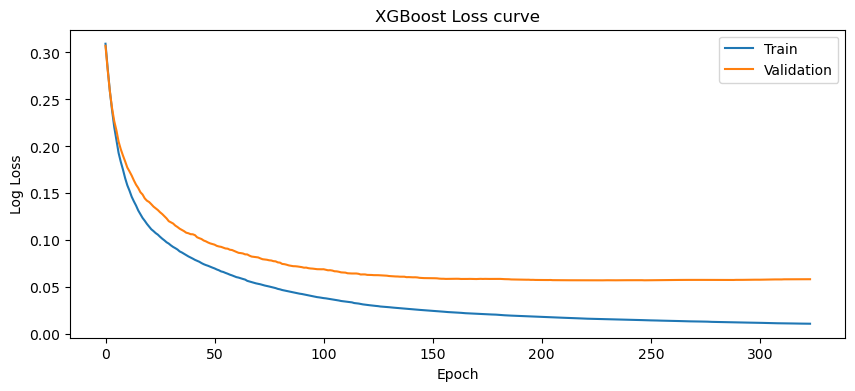

Training score:  0.990368639933801
Validation score:  0.9097987079511554
MAE(O): nan
MAE(H): 0.042


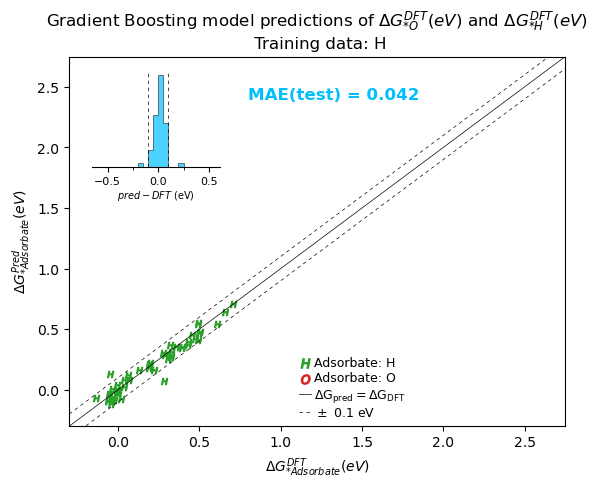

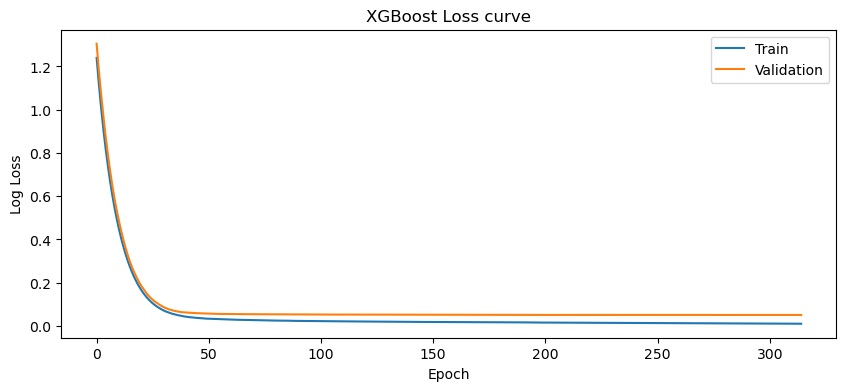

Training score:  0.998051883484083
Validation score:  0.9752267860599123
MAE(O): 0.056
MAE(H): nan


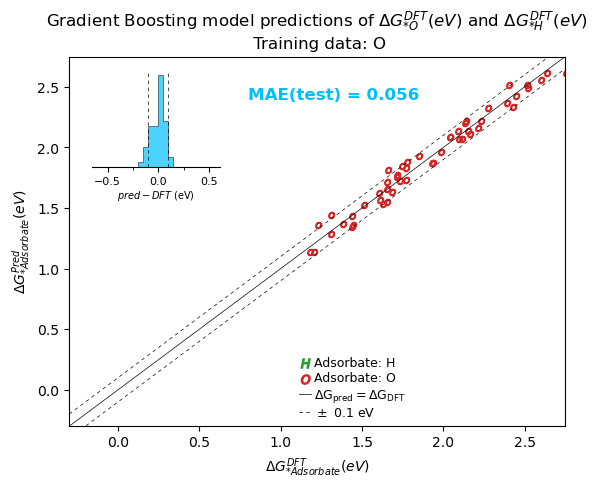

In [10]:
#shuffle and split
X_train, X_val_test, y_train, y_val_test = train_test_split(X_H, y_H, test_size = 0.2)
X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, test_size = 0.5)

# Prepare XGBoost
eval_set = [(X_train, y_train), (X_val, y_val)]
XGBModel_H =  XGBRegressor(learning_rate = 0.1 #learning rate
                                , max_depth = 5     #maximum tree depth
                                , n_estimators = 500 #number of boosting rounds
                                , early_stopping_rounds = 5
                                , n_jobs = 8 #number of threads
                                , use_label_encoder = False)

XGBModel_H.fit(X_train, y_train
                       , eval_set = eval_set
                       , early_stopping_rounds = 100
                       , eval_metric = ["mae"]
                       , verbose = False)

learning_curve(XGBModel_H);

score = XGBModel_H.score(X_train, y_train) #Det må man ikke før den er blevet trænet
print("Training score: ", score)

score = XGBModel_H.score(X_val, y_val) #Det må man ikke før den er blevet trænet
print("Validation score: ", score)

single_parity_plot(XGBModel_H, X_test, y_test, training_data = "H")

# let's try to save the test-set from H and see how well the O model does on it
X_test_H = X_test[:]
y_test_H = y_test[:]

### - NOW O - ###

#shuffle and split
X_train, X_val_test, y_train, y_val_test = train_test_split(X_O, y_O, test_size = 0.2)
X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, test_size = 0.5)

# Prepare XGBoost 
eval_set = [(X_train, y_train), (X_val, y_val)]
XGBModel_O =  XGBRegressor(learning_rate = 0.1 #learning rate
                                , max_depth = 5     #maximum tree depth
                                , n_estimators = 500 #number of boosting rounds
                                , n_jobs = 8 #number of threads
                                , use_label_encoder = False)

XGBModel_O.fit(X_train, y_train
                       , eval_set = eval_set
                       , early_stopping_rounds = 50
                       , eval_metric = ["mae"]
                       , verbose = False) #evals

learning_curve(XGBModel_O);

score = XGBModel_O.score(X_train, y_train) #Det må man ikke før den er blevet trænet
print("Training score: ", score)

score = XGBModel_O.score(X_val, y_val) #Det må man ikke før den er blevet trænet
print("Validation score: ", score)

single_parity_plot(XGBModel_O, X_test, y_test, training_data = "O")

## Quick try with a linear model - How does it stack up against XGBoost?

In [19]:
# Together and seperately
from sklearn.linear_model import LinearRegression

In [20]:
H_df = prepare_csv(feature_folder, "H_features.csv", 0) #H kalder vi 0
O_df = prepare_csv(feature_folder, "O_features.csv", 1) #O kalder vi 1

full_df = pd.concat([H_df, O_df], axis = 0)
all_cols = full_df.columns

#Seperate the energies and remove the useless columns
X = full_df.loc[:, :all_cols[-5]]
y = full_df[["G_ads(eV)"]]

MAE(O): 0.110
MAE(H): 0.114


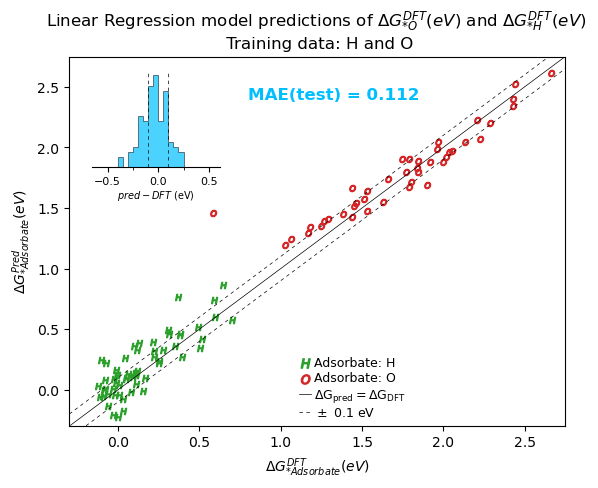

Mean MAE for Linear Regression model O and H:  0.10465350430611227
Mean MAE tested on O:  0.09325502632929959 . Standard deviation:  0.011543651613450428
Mean MAE tested on H:  0.11610180008258518 . Standard deviation:  0.012875782873456844


In [21]:
#shuffle and split
X_train, X_val_test, y_train, y_val_test = train_test_split(X, y, test_size = 0.2)
X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, test_size = 0.5)

linear_model = LinearRegression().fit(X_train, y_train)
#reg.score(X_test, y_test) #Den her lille bølle kan ikke lave MAE, den laver altid R^2
## reg.predict(X_test) # Det her er jo ligesom XGBoost, så min plotter virker på begge!!

single_parity_plot(linear_model, X_test, y_test, training_data = "H and O")

# Run this 100 times
linear_model_O_H_MAE = []
linear_model_O_MAE = []
linear_model_H_MAE = []
for iteration in range(1000):

    X_train, X_val_test, y_train, y_val_test = train_test_split(X, y, test_size = 0.2)
    X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, test_size = 0.5)
    
    #Fit LinearRegression model here
    linear_model_O_H = LinearRegression().fit(X_train, y_train)
    
    MAE_measurement = return_mae(linear_model_O_H, X_test, y_test)
    if MAE_measurement < 10:
        linear_model_O_H_MAE.append(MAE_measurement)
        
    model_predictions = linear_model_O_H.predict(X_test)
    
    if len(np.shape(model_predictions)) == 2:
        model_predictions = model_predictions.reshape(-1)

    flat_list = [item for sublist in X_test[["adsorbate"]].values.tolist() for item in sublist]
    pred_H = [model_predictions[n] for n in range(len(y_test)) if flat_list[n] == 0]
    pred_O = [model_predictions[n] for n in range(len(y_test)) if flat_list[n] == 1]
    y_test = y_test.values.tolist()
    true_H = [y_test[n] for n in range(len(y_test)) if flat_list[n] == 0]
    true_O = [y_test[n] for n in range(len(y_test)) if flat_list[n] == 1]
    
    linear_model_O_MAE.append(np.mean(np.abs(np.array(true_O).reshape(-1)-pred_O)))
    linear_model_H_MAE.append(np.mean(np.abs(np.array(true_H).reshape(-1)-pred_H)))
        
print("Mean MAE for Linear Regression model O and H: ", np.mean(linear_model_O_H_MAE))
print("Mean MAE tested on O: ",  np.mean(linear_model_O_MAE),  ". Standard deviation: ", np.std(linear_model_O_MAE))
print("Mean MAE tested on H: ",  np.mean(linear_model_H_MAE),  ". Standard deviation: ", np.std(linear_model_H_MAE))


MAE(O): nan
MAE(H): 0.041


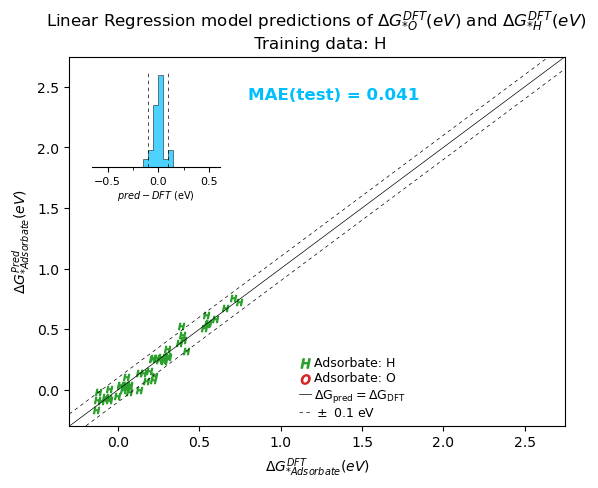

MAE(O): 0.065
MAE(H): nan


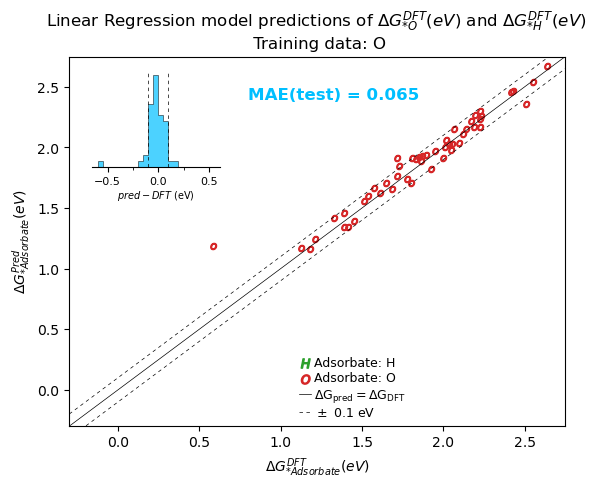

Average model MAE for Linear Regression model H:  0.043333676844702906
Average model MAE for Linear Regression model O:  0.055369413872793684


In [22]:
# Quickly try fitting it on H and then O seperately
X_H = H_df.loc[:, :all_cols[-5]]
y_H = H_df[["G_ads(eV)"]]
X_O = O_df.loc[:, :all_cols[-5]]
y_O = O_df[["G_ads(eV)"]]

linear_model_H_MAE = []
linear_model_O_MAE = []
for iteration in range(110):

    X_train, X_val_test, y_train, y_val_test = train_test_split(X_H, y_H, test_size = 0.2)
    X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, test_size = 0.5)
    
    #Fit LinearRegression model here
    linear_model_H = LinearRegression().fit(X_train, y_train)
    
    MAE_measurement = return_mae(linear_model_H, X_test, y_test)
    if MAE_measurement < 10:
        linear_model_H_MAE.append(MAE_measurement)

single_parity_plot(linear_model_H, X_test, y_test, training_data = "H")

### - NOW O - ###

linear_model_O_MAE = []
for iteration in range(110):

    X_train, X_val_test, y_train, y_val_test = train_test_split(X_O, y_O, test_size = 0.2)
    X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, test_size = 0.5)
    
    #Fit LinearRegression model here
    linear_model_O = LinearRegression().fit(X_train, y_train)
    MAE_measurement = return_mae(linear_model_O, X_test, y_test)
    if MAE_measurement < 10:
        linear_model_O_MAE.append(MAE_measurement)

single_parity_plot(linear_model_O, X_test, y_test, training_data = "O")

print("Average model MAE for Linear Regression model H: ", np.mean(linear_model_H_MAE))
print("Average model MAE for Linear Regression model O: ", np.mean(linear_model_O_MAE))


In [23]:
str(time.time())[6:10]+str(time.time())[11:15] # fra 6 til 12, dog ikke 10

'41039535'

## On-top site model training

At this point I only work with *OH

In [ ]:
# Modify the parity plot for 

In [19]:
# Load dataset
OH_df = prepare_csv(feature_folder, "OH_features.csv", 2) #OH kalder vi 2

all_cols = OH_df.columns
#Seperate the energies and remove the useless columns

X = OH_df.loc[:, :all_cols[-5]]
y = OH_df[["G_ads(eV)"]]

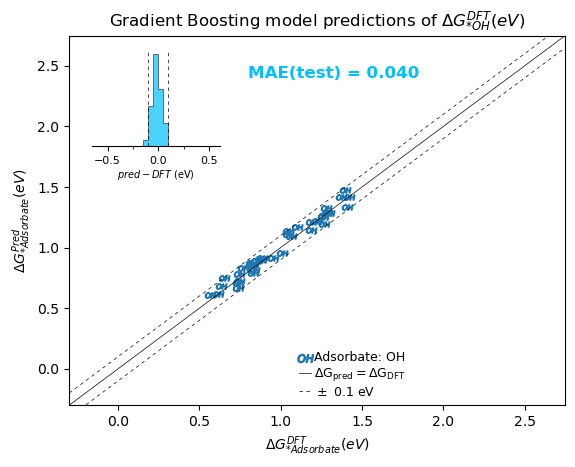

In [32]:
# Prepare dataset
X_train, X_val_test, y_train, y_val_test = train_test_split(X, y, test_size = 0.2)
X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, test_size = 0.5)

# Train model
eval_set = [(X_train, y_train), (X_val, y_val)]
XGBModel_OH =  XGBRegressor(learning_rate = 0.1 #learning rate
                                , max_depth = 5     #maximum tree depth
                                , n_estimators = 500 #number of boosting rounds
                                , n_jobs = 8 #number of threads
                                , use_label_encoder = False)

XGBModel_OH.fit(X_train, y_train
                       , eval_set = eval_set
                       , early_stopping_rounds = 50
                       , eval_metric = ["mae"]
                       , verbose = False) #evals

# Test model
single_parity_plot(XGBModel_OH, X_test, y_test, "OH", adsorbate = "OH")

# Save model
XGBModel_O_H.save_model("../models/"+"on_top_site.model")

# The dump - below this point code is not used anymore

In [24]:
from sklearn.metrics import get_scorer_names
get_scorer_names()

['accuracy',
 'adjusted_mutual_info_score',
 'adjusted_rand_score',
 'average_precision',
 'balanced_accuracy',
 'completeness_score',
 'explained_variance',
 'f1',
 'f1_macro',
 'f1_micro',
 'f1_samples',
 'f1_weighted',
 'fowlkes_mallows_score',
 'homogeneity_score',
 'jaccard',
 'jaccard_macro',
 'jaccard_micro',
 'jaccard_samples',
 'jaccard_weighted',
 'matthews_corrcoef',
 'max_error',
 'mutual_info_score',
 'neg_brier_score',
 'neg_log_loss',
 'neg_mean_absolute_error',
 'neg_mean_absolute_percentage_error',
 'neg_mean_gamma_deviance',
 'neg_mean_poisson_deviance',
 'neg_mean_squared_error',
 'neg_mean_squared_log_error',
 'neg_median_absolute_error',
 'neg_root_mean_squared_error',
 'normalized_mutual_info_score',
 'precision',
 'precision_macro',
 'precision_micro',
 'precision_samples',
 'precision_weighted',
 'r2',
 'rand_score',
 'recall',
 'recall_macro',
 'recall_micro',
 'recall_samples',
 'recall_weighted',
 'roc_auc',
 'roc_auc_ovo',
 'roc_auc_ovo_weighted',
 'roc_auc_